In [1]:
import pandas as pd

In [18]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# set up plotly defaults
pio.renderers.default = "plotly_mimetype+svg"
pio.templates["book"] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350,
        height=250,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        title=dict(x=0.5, xanchor="center"),
    )
)
pio.templates.default = "simple_white+book"

def margin(fig, **kwargs):
    """Set margins for a plotly figure"""
    return fig.update_layout(margin=kwargs)

# Transforming

Data scientists transform columns when they need to change each value in a
feature in the same way. For example, if a feature contains heights of people
in feet, a data scientist might want to transform the heights to centimeters.
In this section, we'll show how to *apply* functions that transform columns of
data using SQL.

In [3]:
#set up connection to database
import sqlalchemy
db = sqlalchemy.create_engine('sqlite:///data/babynames.db')

In [4]:
query = '''
SELECT *
FROM baby
LIMIT 10;
'''
pd.read_sql(query,db)

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
3,Elijah,M,13034,2020
4,William,M,12541,2020
5,James,M,12250,2020
6,Benjamin,M,12136,2020
7,Lucas,M,11281,2020
8,Henry,M,10705,2020
9,Alexander,M,10151,2020


In the baby names New York Times article {cite}`williamsLilith2021`, Pamela
mentions that names starting with the letter "L" and "K" became popular
after 2000. On the other hand, names starting with the letter "J" peaked in
popularity in the 1970s and 1980s and have dropped off in popularity since. We
can verify these claims using the `baby` dataset.

We approach this problem using the following steps:

1. Transform the `Name` column into a new column that contains the first
   letters of each value in `Name`.
2. Group the dataframe by the first letter and year.
3. Aggregate the name counts by summing.

To complete the first step, we'll apply a function to the `Name` column. 

## SQL Functions

SQLite provides scalar functions, or functions that transform single data
values. When called on a column of data, SQLite will apply these functions on
each value in the column. In contrast, aggregation functions like `SUM` and
`COUNT` take a column of values as input and compute a single value as output.

SQLite provides a comprehensive list of the built-in scalar functions on its
website [^funcs]. For instance, to find the lengths of each name, we use the
`LENGTH` function.

[^funcs]: https://www.sqlite.org/lang_corefunc.html

In [5]:
query = '''
SELECT Year, LENGTH(Name)
FROM baby
LIMIT 10;
'''
pd.read_sql(query,db)

,Year,LENGTH(Name)
0,2020,4
1,2020,4
2,2020,6
3,2020,6
4,2020,7
5,2020,5
6,2020,8
7,2020,5
8,2020,5
9,2020,9


Notice that the `LENGTH` function is applied to each value within the `Name`
column.

:::{note}

Like aggregation functions, each implementation of SQL provides a different set
of scalar functions. SQLite has a relatively minimal set of functions, while
PostgreSQL has many more [^pg_funcs]. Most SQL implementations provide some
equivalent to SQLite's `LENGTH`, `ROUND`, `SUBSTR`, and `LIKE` functions. 

:::

[^pg_funcs]: https://www.postgresql.org/docs/9.2/functions.html

Calling a scalar function uses the same syntax as an aggregation function. This
can result in confusing output if the two are mixed together in a single query:

In [8]:
query = ''' 
SELECT Name, LENGTH(Name), COUNT(Name)
FROM baby
LIMIT 10;
'''

pd.read_sql(query, db)

,Name,LENGTH(Name),COUNT(Name)
0,Liam,4,2020722


For this reason, we must be careful when when scalar and aggregation functions
appear together within a `SELECT` statement. 

To extract the first letter of each name, we can use the `SUBSTR` function
(short for "substring"). As described in the documentation, the `SUBSTR`
function takes three arguments. The first is the input string, the second is
the position to begin the substring (1-indexed), and the third is the
length of the substring.

In [10]:
query = '''
SELECT Name, SUBSTR(Name,1,1)
FROM baby
LIMIT 10;
'''
pd.read_sql(query,db)

,Name,"SUBSTR(Name,1,1)"
0,Liam,L
1,Noah,N
2,Oliver,O
3,Elijah,E
4,William,W
5,James,J
6,Benjamin,B
7,Lucas,L
8,Henry,H
9,Alexander,A


Now, we can use the `AS` keyword to rename the column:

In [12]:
query = '''
SELECT *, SUBSTR(Name,1,1) AS Firsts
FROM baby
LIMIT 10;
'''
pd.read_sql(query,db)

,Name,Sex,Count,Year,Firsts
0,Liam,M,19659,2020,L
1,Noah,M,18252,2020,N
2,Oliver,M,14147,2020,O
3,Elijah,M,13034,2020,E
4,William,M,12541,2020,W
5,James,M,12250,2020,J
6,Benjamin,M,12136,2020,B
7,Lucas,M,11281,2020,L
8,Henry,M,10705,2020,H
9,Alexander,M,10151,2020,A


This completes step 1 of our analysis plan. SQL provides several options to
break queries into smaller steps, which is helpful in a more complex analysis
like this one. One option is to create an entirely new relation using the
`CREATE TABLE` statement. Another option is to use the `WITH` keyword to
create a temporary relation just for the query at hand. We'll demonstrate 
the `WITH` keyword for this example.

## Multistep Queries Using a `WITH` Clause

The `WITH` clause lets us assign a name to any `SELECT` query. Then, we can
treat that query as though it exists as a relation in the database. For
instance, we can take the query above that calculates the first letter of each
name and call it `letters`:

In [14]:
query = '''
WITH letters AS (
  SELECT *, SUBSTR(Name,1,1) AS Firsts
  FROM baby
)
SELECT *
FROM letters
LIMIT 10;
'''

pd.read_sql(query,db)

,Name,Sex,Count,Year,Firsts
0,Liam,M,19659,2020,L
1,Noah,M,18252,2020,N
2,Oliver,M,14147,2020,O
3,Elijah,M,13034,2020,E
4,William,M,12541,2020,W
5,James,M,12250,2020,J
6,Benjamin,M,12136,2020,B
7,Lucas,M,11281,2020,L
8,Henry,M,10705,2020,H
9,Alexander,M,10151,2020,A


We can read this query as follows:

```sql
-- Create a temporary relation called letters by calculating the first
-- letters for each name in baby
WITH letters AS (               
  SELECT *,   
    SUBSTR(Name, 1, 1) AS Firsts 
  FROM baby
)
-- Then, select the first ten rows from letters
SELECT *
FROM letters
LIMIT 10;
```

`WITH` statements are highly useful since they can be chained together. We can
create multiple temporary relations in a `WITH` statement that each perform a
bit of work on the previous result, which lets us gradually build complicated
queries a step at a time. 

## Example: Popularity of "L" Names

Now, we can perform the next steps in our analysis. We'll group the relation by the
first letter and year, then aggregate the `Count` column using a sum.

In [15]:
query = '''
WITH letters AS(
  SELECT *, SUBSTR(Name,1,1) AS Firsts
  FROM baby
  )
SELECT Firsts, Year, SUM(Count) AS count
FROM letters
GROUP BY Firsts, Year;
'''
letters_counts = pd.read_sql(query,db)
letters_counts

,Firsts,Year,count
0,A,1880,16740
1,A,1881,16257
2,A,1882,18790
3,A,1883,18831
4,A,1884,20898
...,...,...,...
3636,Z,2016,54679
3637,Z,2017,54495
3638,Z,2018,55996
3639,Z,2019,55293


Finally, we use `plotly` to plot the popularity of "L" names over time:

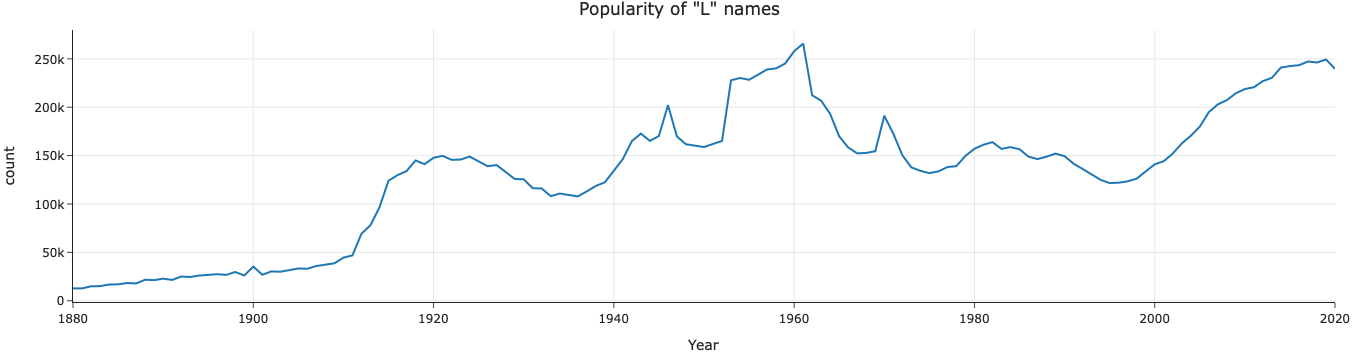

In [20]:
fig=px.line(letters_counts.loc[letters_counts['Firsts'] == 'L'],
        x='Year',y='count',title='Popularity of "L" names',
        width = 350, height = 250)
margin(fig, t=30)

The plot shows that "L" names were popular in the 1960s, dipped in the decades
after, but have indeed resurged in popularity after 2000. 

What about "J" names?

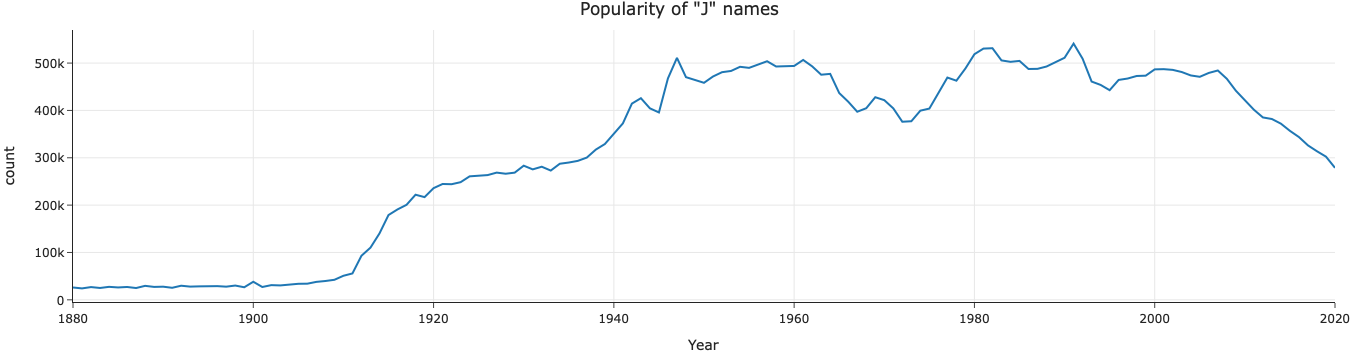

In [21]:
fig = px.line(letters_counts.loc[letters_counts['Firsts']=='J'],
              x='Year',y='count',title='Popularity of "J" names',
              width = 350, height = 250)
margin(fig,t=30)

The NYT article says that "J" names were popular in the 1970s and 80s. The plot
agrees, and also shows that they have become less popular after 2000.

## Takeaways

To transform values in a relation, we commonly use SQL functions like
`LENGTH()` or `SUBSTR()`.
We also explained how to build up complex queries using the `WITH` clause.
In the next section, we'll compare relations with other ways to represent and
manipulate data tables.